In [17]:
from absl import app, flags
from easydict import EasyDict
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
from torch.utils.data import TensorDataset, DataLoader

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.torch.attacks.hop_skip_jump_attack import hop_skip_jump_attack
from cleverhans.torch.attacks.noise import noise
# from cleverhans.torch.attacks.semantic import semantic
from cleverhans.torch.attacks.sparse_l1_descent import sparse_l1_descent
from cleverhans.torch.attacks.spsa import spsa

device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
class fc_output(torch.nn.Module):

    def __init__(self, n_classes, pretrained_model, pretrained_model_output):
        super(fc_output, self).__init__()
        
        for param in pretrained_model.parameters():
            param.requires_grad = False  # freeze pretrained layers
            
        self.pretrained = pretrained_model
        self.final_fc = nn.Sequential(nn.ReLU(),
                                      nn.Linear(pretrained_model_output, n_classes))

    def forward(self, x):
        x = self.pretrained(x)
        x = self.final_fc(x)
        return x

def ld_mnist(train, test):
    return EasyDict(train=train, test=test)
    
def semantic(x, center=True, max_val=1.0):
    if center:
        return x * -1
    return max_val - x
    

In [45]:
def plot_images(x, x_fgm, x_pgd, x_noise, x_semantic, x_l1, x_spsa, x_l2, x_hop_skip, y_pred, y_pred_fgm, 
                y_pred_pgd, y_pred_l2, y_pred_hop_skip, y_pred_noise, y_pred_l1, y_pred_spsa, y_pred_semantic, path):
    print(path)
    
    real_image = x.squeeze(0).cpu().detach().numpy()
    fgm_image = x_fgm.squeeze(0).cpu().detach().numpy() 
    pgd_image = x_pgd.squeeze(0).cpu().detach().numpy()
    noise_image = x_noise.squeeze(0).cpu().detach().numpy()
    semantic_image = x_semantic.squeeze(0).cpu().detach().numpy()
    l1_image = x_l1.squeeze(0).cpu().detach().numpy()
    spsa_image = x_spsa.squeeze(0).cpu().detach().numpy()
    l2_image = x_l2.squeeze(0).cpu().detach().numpy()
    hop_skip_image = x_hop_skip.squeeze(0).cpu().detach().numpy()


        
    f, axs = plt.subplots(1,9,figsize=(15,15))
    
    for i in range(9):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
    axs[0].imshow(real_image, cmap='gray')
    axs[0].set_title("real")
    axs[0].set_xlabel(y_pred)
    
    axs[1].imshow(fgm_image, cmap='gray')
    axs[1].set_title("fgm")
    axs[1].set_xlabel(y_pred_fgm)
    
    axs[2].imshow(pgd_image, cmap='gray')
    axs[2].set_title("pgd")
    axs[2].set_xlabel(y_pred_pgd)
    
    axs[3].imshow(noise_image, cmap='gray')
    axs[3].set_title("noise")
    axs[3].set_xlabel(y_pred_noise)
    
    
    axs[4].imshow(semantic_image, cmap='gray')
    axs[4].set_title("semantic")
    axs[4].set_xlabel(y_pred_semantic)
    
    axs[5].imshow(l1_image, cmap='gray')
    axs[5].set_title("l1")
    axs[5].set_xlabel(y_pred_l1)
    

    axs[6].imshow(spsa_image, cmap='gray')
    axs[6].set_title("spsa")
    axs[6].set_xlabel(y_pred_spsa)
        
        
    axs[7].imshow(l2_image, cmap='gray')
    axs[7].set_title("l2")
    axs[7].set_xlabel(y_pred_l2)
    
    
    axs[8].imshow(hop_skip_image, cmap='gray')
    axs[8].set_title("hop_skip")
    axs[8].set_xlabel(y_pred_hop_skip)
    
    
    plt.savefig(path)
    
    

In [58]:
class CNN(torch.nn.Module):
    def __init__(self, in_channels=1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, 64, 8, 1
        )  # (batch_size, 3, 28, 28) --> (batch_size, 64, 21, 21)
        self.conv2 = nn.Conv2d(
            64, 128, 6, 2
        )  # (batch_size, 64, 21, 21) --> (batch_size, 128, 8, 8)
        self.conv3 = nn.Conv2d(
            128, 128, 5, 1
        )  # (batch_size, 128, 8, 8) --> (batch_size, 128, 4, 4)
        self.fc1 = nn.Linear(
            128 * 4 * 4, 128
        )  # (batch_size, 128, 4, 4) --> (batch_size, 2048)
        self.fc2 = nn.Linear(128, 10)  # (batch_size, 128) --> (batch_size, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

def mnist_data():
    mnist_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))])

    mnist_train = torchvision.datasets.MNIST('/files/', train=True, download=True,
                                 transform=mnist_transform)
    # len(mnist_train) = 60,000 

    mnist_test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                                 transform=mnist_transform)
    # len(mnist_test) = 10,000


    # ------ CREATE OWN TEST DATA SET -------
    mnist_x_subset = []
    mnist_y_subset = []
    choice_size = 1

    # for i in range(10):
    #     random_idxs = np.random.choice(np.where(mnist_test.targets==i)[0], choice_size)

    #     for idx in random_idxs:
    #         # mnist_x_subset.append(mnist_test.data[idx].unsqueeze(0).repeat(3,1,1))  # add new rgb channel

    #         # [28, 28] -> [1, 1, 28, 28] -> [1, 1, 227, 227] -> [3, 227, 227]
    #         #mnist_x_subset.append(F.interpolate(mnist_test.data[idx].unsqueeze(0).unsqueeze(0), 
    #         #                                    size=(alexnet_img_size, alexnet_img_size)).squeeze(0).repeat(3,1,1))   
    #         mnist_x_subset.append(mnist_test.data[idx].unsqueeze(0)) 
    #         mnist_y_subset.append(mnist_test.targets[idx])  # add targets to new list 



    # tensor_mnist_x = torch.Tensor([t.numpy() for t in mnist_x_subset]) # transform to torch tensor
    # tensor_mnist_y = torch.Tensor(mnist_y_subset)

    # mnist_test_subset = TensorDataset(tensor_mnist_x,tensor_mnist_y) # create your datset
    
    mnist_train_subset = torch.utils.data.Subset(mnist_train, range(0, len(mnist_train), 60))  # take every 60th data.
    mnist_test_subset = torch.utils.data.Subset(mnist_test, range(0, len(mnist_test), 50))  # take every 10th data.

    batch_size=1
    mnist_train_loader = DataLoader(mnist_train_subset, batch_size=batch_size, shuffle=True)
    mnist_test_loader = DataLoader(mnist_test_subset, batch_size=batch_size, shuffle=True)

    # Load training and test data
    data = ld_mnist(mnist_train_loader, mnist_test_loader)
    
    return data


def train_mnist_net(data):
    epochs = 10

    # Instantiate model, loss, and optimizer for training
    #alexnet = models.alexnet(pretrained=True)  # use pretriauned alexnet
    #mnist_alexnet = fc_output(n_classes=10, pretrained_model=alexnet, pretrained_model_output=1000)
    #mnist_alexnet.to(device)

    net = CNN(in_channels=1)
    net.to(device)
    loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

    net.train()
    for epoch in range(1, epochs + 1):
        train_loss = 0.0
        for x, y in data.train:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            loss = loss_fn(net(x), y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print("epoch: {}/{}, train loss: {:.3f}".format(epoch, epochs, train_loss))
        
    return net

def validate_mnist_net(net, data, save=False):
    eps = 0.3
    path="data/mnist/labels/"
    # Evaluate on clean and adversarial data

    net.eval()
    net = net.to(device)

    report = EasyDict(nb_test=0, correct=0, correct_fgm=0, correct_pgd=0, 
                      correct_l2=0, correct_hop_skip=0, correct_noise=0,
                     correct_semantic=0, correct_l1=0, correct_spsa=0,
                     y_pred=[], y_pred_fgm=[], y_pred_pgd=[],
                     y_pred_l2=[], y_pred_hop_skip=[], y_pred_noise=[], y_pred_semantic=[],
                     y_pred_l1=[], y_pred_spsa=[], time=[])


    for i, (x, y) in enumerate(tqdm(data.test)):
        x, y = x.to(device), y.to(device)

        # -------- BASE MODEL -----
        _, y_pred = net(x).max(1)  # model prediction on clean examples
        # -------- BASE MODEL -----


        # --------- FGM -----------
        start = time.time()
        x_fgm = fast_gradient_method(net, x, eps, np.inf)
        _, y_pred_fgm = net(x_fgm).max(1)  # model prediction on FGM adversarial examples
        print("FGM complete")
        end = time.time()

        report.time.append(end-start)
        # --------- FGM -----------

        # --------- PGD -----------
        start = time.time()
        x_pgd = projected_gradient_descent(net, x, eps, 0.01, 40, np.inf)
        _, y_pred_pgd = net(x_pgd).max(1)  # model prediction on PGD adversarial examples
        end = time.time()
        print("PGD complete")
        report.time.append(end-start)
        # --------- PGD -----------


        # --------- NOISE -----------
        start = time.time()
        x_noise = noise(x)
        _, y_pred_noise = net(x_noise).max(1)
        end = time.time()
        print("NOISE complete")
        report.time.append(end-start)
        # --------- NOISE -----------


        # --------- SEMANTIC -----------
        start = time.time()
        x_semantic = semantic(x, center=False)  # latest pip package has outdated function.
        _, y_pred_semantic = net(x_semantic).max(1)

        end = time.time()
        print("SEMANTIC complete")
        report.time.append(end-start)
        # --------- SEMANTIC -----------


        # --------- L1 -----------
        start = time.time()
        x_l1 = sparse_l1_descent(net, x)
        _, y_pred_l1 = net(x_l1).max(1)
        end = time.time()
        print("L1 complete")
        report.time.append(end-start)
        # --------- L1 -----------


        # --------- SPSA -----------
        start = time.time()
        x_spsa = spsa(net, x, eps, nb_iter=3, sanity_checks=False)
        _, y_pred_spsa = net(x_spsa).max(1)
        end = time.time()
        print("SPSA complete")
        report.time.append(end-start)
        # --------- SPSA -----------


        # --------- L2 -----------
        start = time.time()
        x_l2 = carlini_wagner_l2(net, x, n_classes=10)
        _, y_pred_l2 = net(x_l2).max(1)
        end = time.time()
        print("L2 complete")
        report.time.append(end-start)
        # --------- L2 -----------


        # --------- HSP -----------
        start = time.time()
        x_hop_skip = hop_skip_jump_attack(net, x, np.inf, verbose=False)
        _, y_pred_hop_skip = net(x_hop_skip).max(1)
        end = time.time()
        print("HSP complete")
        report.time.append(end-start)
        # --------- HSP -----------

        report.y_pred.append(y_pred)
        report.y_pred_fgm.append(y_pred_fgm)
        report.y_pred_pgd.append(y_pred_pgd)
        report.y_pred_noise.append(y_pred_noise)
        report.y_pred_semantic.append(y_pred_semantic)
        report.y_pred_l1.append(y_pred_l1)
        report.y_pred_spsa.append(y_pred_spsa)
        report.y_pred_l2.append(y_pred_l2)
        report.y_pred_hop_skip.append(y_pred_hop_skip)

        report.nb_test += y.size(0)
        report.correct += y_pred.eq(y).sum().item()
        report.correct_fgm += y_pred_fgm.eq(y).sum().item()
        report.correct_pgd += y_pred_pgd.eq(y).sum().item()
        report.correct_l2 += y_pred_l2.eq(y).sum().item()
        report.correct_hop_skip += y_pred_hop_skip.eq(y).sum().item()
        report.correct_noise += y_pred_noise.eq(y).sum().item()
        report.correct_semantic += y_pred_semantic.eq(y).sum().item()
        report.correct_l1 += y_pred_l1.eq(y).sum().item()    
        report.correct_spsa += y_pred_spsa.eq(y).sum().item() 
        
        updated_path = "{0}/{2}-image-{1}.png".format(path, y[0], i)
        for h in report.time:
            print("{0:.4f} &".format(h))
        
        
        plot_images(x[0], x_fgm[0], x_pgd[0], x_noise[0], x_semantic[0], x_l1[0], x_spsa[0], x_l2[0], x_hop_skip[0], 
                    y_pred[0].item(), y_pred_fgm[0].item(), y_pred_pgd[0].item(), y_pred_l2[0].item(), 
                    y_pred_hop_skip[0].item(), y_pred_noise[0].item(), 
                    y_pred_l1[0].item(), y_pred_spsa[0].item(), y_pred_semantic[0].item(), path=updated_path)
            
            

#         if save:
#             for _y, _x, _x_fgm, _x_pgd, _x_noise, _x_semantic, _x_l1, _x_spsa, _x_l2, _x_hop \
#             in zip(y, x, x_fgm, x_pgd, x_noise, x_semantic, x_l1, x_spsa, x_l2, x_hop_skip):
#                 updated_path = "{0}/{2}-image-{1}.png".format(path, _y, i)
#                 plot_images(_x, _x_fgm, _x_pgd, _x_noise, _x_semantic, _x_l1, _x_spsa, _x_l2, _x_hop,
#                             y_pred[0], y_pred_fgm[0], y_pred_pgd[0], y_pred_l2[0], 
#                             y_pred_hop_skip[0], y_pred_noise[0], y_pred_semantic[0],
#                             y_pred_l1[0], y_pred_spsa[0], path=updated_path)

#         print("test acc on clean examples (%): {:.3f}".format(report.correct / report.nb_test * 100.0))
#         print("test acc on FGM adversarial examples (%): {:.3f}".format(report.correct_fgm / report.nb_test * 100.0))
#         print("test acc on PGD adversarial examples (%): {:.3f}".format(report.correct_pgd / report.nb_test * 100.0))
#         print("test acc on L2 adversarial examples (%): {:.3f}".format(report.correct_l2 / report.nb_test * 100.0))
#         print("test acc on HOP-SKIP-JUMP adversarial examples (%): {:.3f}".format(report.correct_hop_skip / report.nb_test * 100.0))
#         print("test acc on NOISE adversarial examples (%): {:.3f}".format(report.correct_noise / report.nb_test * 100.0))
#         print("test acc on SEMANTIC adversarial examples (%): {:.3f}".format(report.correct_semantic / report.nb_test * 100.0))
#         print("test acc on L1 adversarial examples (%): {:.3f}".format(report.correct_l1 / report.nb_test * 100.0))
#         print("test acc on SPSA adversarial examples (%): {:.3f}".format(report.correct_spsa / report.nb_test * 100.0))

    with open("{0}/report.txt".format(path), 'w+') as f:
        for key in report:
            f.write("{0}: {1}\n".format(key, report[key]))
        f.write("test acc on clean examples (%): {:.3f}\n".format(report.correct / report.nb_test * 100.0))
        f.write("test acc on FGM adversarial examples (%): {:.3f}\n".format(report.correct_fgm / report.nb_test * 100.0))
        f.write("test acc on PGD adversarial examples (%): {:.3f}\n".format(report.correct_pgd / report.nb_test * 100.0))
        f.write("test acc on L2 adversarial examples (%): {:.3f}\n".format(report.correct_l2 / report.nb_test * 100.0))
        f.write("test acc on HOP-SKIP-JUMP adversarial examples (%): {:.3f}\n".format(report.correct_hop_skip / report.nb_test * 100.0))
        f.write("test acc on NOISE adversarial examples (%): {:.3f}\n".format(report.correct_noise / report.nb_test * 100.0))
        f.write("test acc on SEMANTIC adversarial examples (%): {:.3f}\n".format(report.correct_semantic / report.nb_test * 100.0))
        f.write("test acc on L1 adversarial examples (%): {:.3f}\n".format(report.correct_l1 / report.nb_test * 100.0))
        f.write("test acc on SPSA adversarial examples (%): {:.3f}\n".format(report.correct_spsa / report.nb_test * 100.0))

#     print("test acc on clean examples (%): {:.3f}".format(report.correct / report.nb_test * 100.0))
#     print("test acc on FGM adversarial examples (%): {:.3f}".format(report.correct_fgm / report.nb_test * 100.0))
#     print("test acc on PGD adversarial examples (%): {:.3f}".format(report.correct_pgd / report.nb_test * 100.0))
#     print("test acc on L2 adversarial examples (%): {:.3f}".format(report.correct_l2 / report.nb_test * 100.0))
#     print("test acc on HOP-SKIP-JUMP adversarial examples (%): {:.3f}".format(report.correct_hop_skip / report.nb_test * 100.0))
#     print("test acc on NOISE adversarial examples (%): {:.3f}".format(report.correct_noise / report.nb_test * 100.0))
#     print("test acc on SEMANTIC adversarial examples (%): {:.3f}".format(report.correct_semantic / report.nb_test * 100.0))
#     print("test acc on L1 adversarial examples (%): {:.3f}".format(report.correct_l1 / report.nb_test * 100.0))
#     print("test acc on SPSA adversarial examples (%): {:.3f}".format(report.correct_spsa / report.nb_test * 100.0))
    return report
    

In [30]:
data = mnist_data()

In [26]:
net = train_mnist_net(data)

epoch: 1/10, train loss: 36.092
epoch: 2/10, train loss: 13.110
epoch: 3/10, train loss: 8.592
epoch: 4/10, train loss: 5.288
epoch: 5/10, train loss: 5.515
epoch: 6/10, train loss: 2.317
epoch: 7/10, train loss: 1.528
epoch: 8/10, train loss: 0.484
epoch: 9/10, train loss: 0.693
epoch: 10/10, train loss: 0.430


FGM complete
PGD complete
NOISE complete
SEMANTIC complete
L1 complete
SPSA complete
L2 complete
HSP complete
0.0020 &
0.0660 &
0.0000 &
0.0010 &
0.0240 &
0.0290 &
11.2519 &
2.2841 &
data/mnist/labels//0-image-9.png
FGM complete
PGD complete
NOISE complete
SEMANTIC complete
L1 complete
SPSA complete



KeyboardInterrupt: 

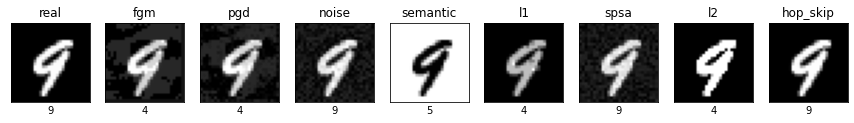

In [59]:
validate_mnist_net(net, data, save=False)